In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [5]:
# Convert subtitle file into CSV
subtitle_files = glob.glob('occupancy_estimation_by_human/*.ass')
subtitle_files.sort()
for file in subtitle_files:
#     print(type(file))
    with open(file, 'r') as subtitle_file:
        for _ in range(26):
            next(subtitle_file)
        with open(file.replace('_ffmpeg_with_interest_area.ass','.csv'), 'w') as csv_file:
            for line in subtitle_file:
                csv_file.write(line.replace('Dialogue: ','').replace('Format: ','').replace(' ', ''))

read file: occupancy_estimation_by_human\Camera1_Sep_17_1300_1400_Parameterized_Learning_Agent.csv
openpose file select:occupancy_estimation/occupancy_estimation_camera1_combined/Sep_17\Camera1_Sep_17_1300_1400_Parameterized_Learning_Agent_processed_occupancy_whole_COCO_736_3.csv


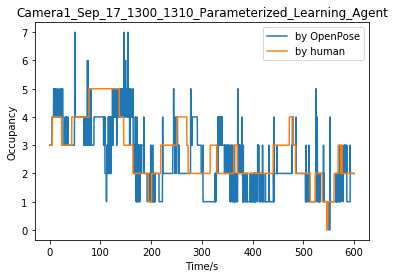

In [15]:
# Read data from human estimation
human_estimation_files = glob.glob('occupancy_estimation_by_human/*.csv')
human_estimation_files.sort()
for file in human_estimation_files:
    print("read file: {}".format(file))
    human_estimation = pd.read_csv(file) # only one file is available here ----> Sept 17
    human_estimation = human_estimation.drop(columns = ['Layer','Style','Name','MarginL','MarginR','MarginV','Effect'])
    human_estimation = human_estimation.rename(index=str, columns={'Text':'Occupancy'})
    
    ### Convert datetime to seconds ###
    exp_start_time = datetime.strptime('2018-09-17 13:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
    start_time_in_s = []
    end_time_in_s = []
    for index,row in human_estimation.iterrows():
    #     print(type(row['Start']))
        full_start_time = '2018-09-17 '+ row['Start']
        full_end_time = '2018-09-17 '+ row['End']
        current_start_time = datetime.strptime(full_start_time, '%Y-%m-%d %H:%M:%S.%f') + timedelta(hours=13)
        current_end_time = datetime.strptime(full_end_time, '%Y-%m-%d %H:%M:%S.%f') + timedelta(hours=13)

        start_time_in_s.append((current_start_time-exp_start_time).total_seconds())
        end_time_in_s.append((current_end_time-exp_start_time).total_seconds())
    human_estimation.insert(loc=1,column='Start_s', value=start_time_in_s)
    human_estimation.insert(loc=3,column='End_s', value=end_time_in_s)
#     human_estimation
    
    ### Read data from OpenPose estimation ###
    openpose_files = glob.glob('occupancy_estimation/occupancy_estimation_camera1_combined/Sep_17/*.csv')
    file_name_split = file.split('\\')[1].split('_')
    time_and_date = file_name_split[1] + '_' + file_name_split[2] + '_' + file_name_split[3] + '_' + file_name_split[4]
    for f in openpose_files:
    #     print(f)
        if ('whole' in f) and (time_and_date in f):
            openpose_estimation = pd.read_csv(f)
            print('openpose file select:{}'.format(f))
    #     if 'core' in f:
    #         occupancy_core = pd.read_csv(f)
    #     if 'margin' in f:
    #         occupancy_margin = pd.read_csv(f)

    ### Fill out human observation data according to OpenPose data's frequency ###
    human_estimation_filled = pd.DataFrame(columns = ["Time", "Occupancy"])
    for _,he_row in human_estimation.iterrows():
        openpose_records_in_range = openpose_estimation.loc[openpose_estimation["Time"]>=he_row["Start_s"]*1000].loc[openpose_estimation["Time"]<he_row["End_s"]*1000]
        for _,op_record in openpose_records_in_range.iterrows():
            human_estimation_filled.loc[len(human_estimation_filled)] = {"Time":op_record["Time"], "Occupancy":he_row["Occupancy"]}

    #### Get data for first 10 minutes and plot ###
    openpose_estimation = openpose_estimation.loc[openpose_estimation['Time']<=10*60*1000]
    human_estimation_filled = human_estimation_filled.loc[human_estimation_filled['Time']<10*60*1000]

    plt.figure()
    plt.plot(openpose_estimation['Time']/1000, openpose_estimation['Occupancy'], label='by OpenPose')
    plt.plot(human_estimation_filled['Time']/1000, human_estimation_filled['Occupancy'], label='by human')
    plt.legend(loc='upper right')
    plt.xlabel('Time/s')
    plt.ylabel('Occupancy')
    plt.title(file.split('\\')[1].replace('.csv','').replace('1400','1310'))

In [14]:
file_name_split = file.split('\\')[1].split('_')
time_and_date = file_name_split[1] + '_' + file_name_split[2] + '_' + file_name_split[3] + '_' + file_name_split[4]
time_and_date

'Sep_17_1300_1400'

In [10]:
human_estimation

,Start,Start_s,End,End_s,Occupancy
0,0:00:00.00,0.00,0:00:05.00,5.00,3
1,0:00:05.00,5.00,0:00:23.20,23.20,4
2,0:00:23.20,23.20,0:00:43.30,43.30,3
3,0:00:43.30,43.30,0:01:17.30,77.30,4
4,0:01:17.30,77.30,0:02:17.00,137.00,5
5,0:02:17.00,137.00,0:02:25.66,145.66,4
6,0:02:25.66,145.66,0:02:44.00,164.00,3
7,0:02:44.00,164.00,0:03:14.00,194.00,2
8,0:03:14.00,194.00,0:03:20.60,200.60,1
9,0:03:20.60,200.60,0:03:38.60,218.60,2
